# Comparison between Nestorov and normal momentum approaches 

## Import libreries and define global variables

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [2]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [3]:
df = get_data(f'{DIR}data/MONK/monks-1.train')
df_test = get_data(f'{DIR}data/MONK/monks-1.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [4]:
test_frac = 1/4

In [5]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [6]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [7]:
preprocessing = 0

In [8]:
if preprocessing == 1:
    X_train_cup = minmax_norm(X_train_cup)
    X_test_cup = minmax_norm(X_test_cup)
elif preprocessing == 2:
    X_train_cup = standard(X_train_cup)
    X_test_cup = standard(X_test_cup)

## MONK

Define training and model hyperparameters

In [16]:
orig_params = {'hidden_dim': 4,
        'hidden_act_func': 'tanh',
        'eta': 0.5,
        'lam': 0.0,
        'alpha': 0.9,
        'n_batch': 124,
        'use_opt':0,
        'nest': False,
        'l1_reg' : False,
        'epochs' : 500
        }

seed = np.random.randint(10,10000)

### Normal momentum

Build model

In [17]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'), init_weights_mode='rand')
output_layer = Layer(hidden_layer, 1, 'sigm', init_weights_mode='rand')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

init_weights_list = model.get_weights_list()

Training with normal momentum:

In [18]:
np.random.seed(seed)
params['nest'] = False
history_nonest = model.retrain(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    test_data = [X_test_monk, y_test_monk.reshape((1,X_test_monk.shape[1]))],
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )

Epoch 0: train_loss: 6.670e-01, test_loss: 6.781e-01; train_accuracy: 6.048e+01, test_accuracy: 5.787e+01  train_MSE: 2.371e-01, test_MSE: 2.426e-01  lr : 0.5
Epoch 1: train_loss: 6.548e-01, test_loss: 6.690e-01; train_accuracy: 6.210e+01, test_accuracy: 6.042e+01  train_MSE: 2.311e-01, test_MSE: 2.381e-01  lr : 0.5
Epoch 2: train_loss: 6.393e-01, test_loss: 6.582e-01; train_accuracy: 6.452e+01, test_accuracy: 5.903e+01  train_MSE: 2.236e-01, test_MSE: 2.329e-01  lr : 0.5
Epoch 3: train_loss: 6.210e-01, test_loss: 6.464e-01; train_accuracy: 6.613e+01, test_accuracy: 6.181e+01  train_MSE: 2.149e-01, test_MSE: 2.272e-01  lr : 0.5
Epoch 4: train_loss: 5.989e-01, test_loss: 6.327e-01; train_accuracy: 6.613e+01, test_accuracy: 6.366e+01  train_MSE: 2.046e-01, test_MSE: 2.207e-01  lr : 0.5
Epoch 5: train_loss: 5.720e-01, test_loss: 6.172e-01; train_accuracy: 6.855e+01, test_accuracy: 6.551e+01  train_MSE: 1.926e-01, test_MSE: 2.136e-01  lr : 0.5
Epoch 6: train_loss: 5.420e-01, test_loss: 6.0

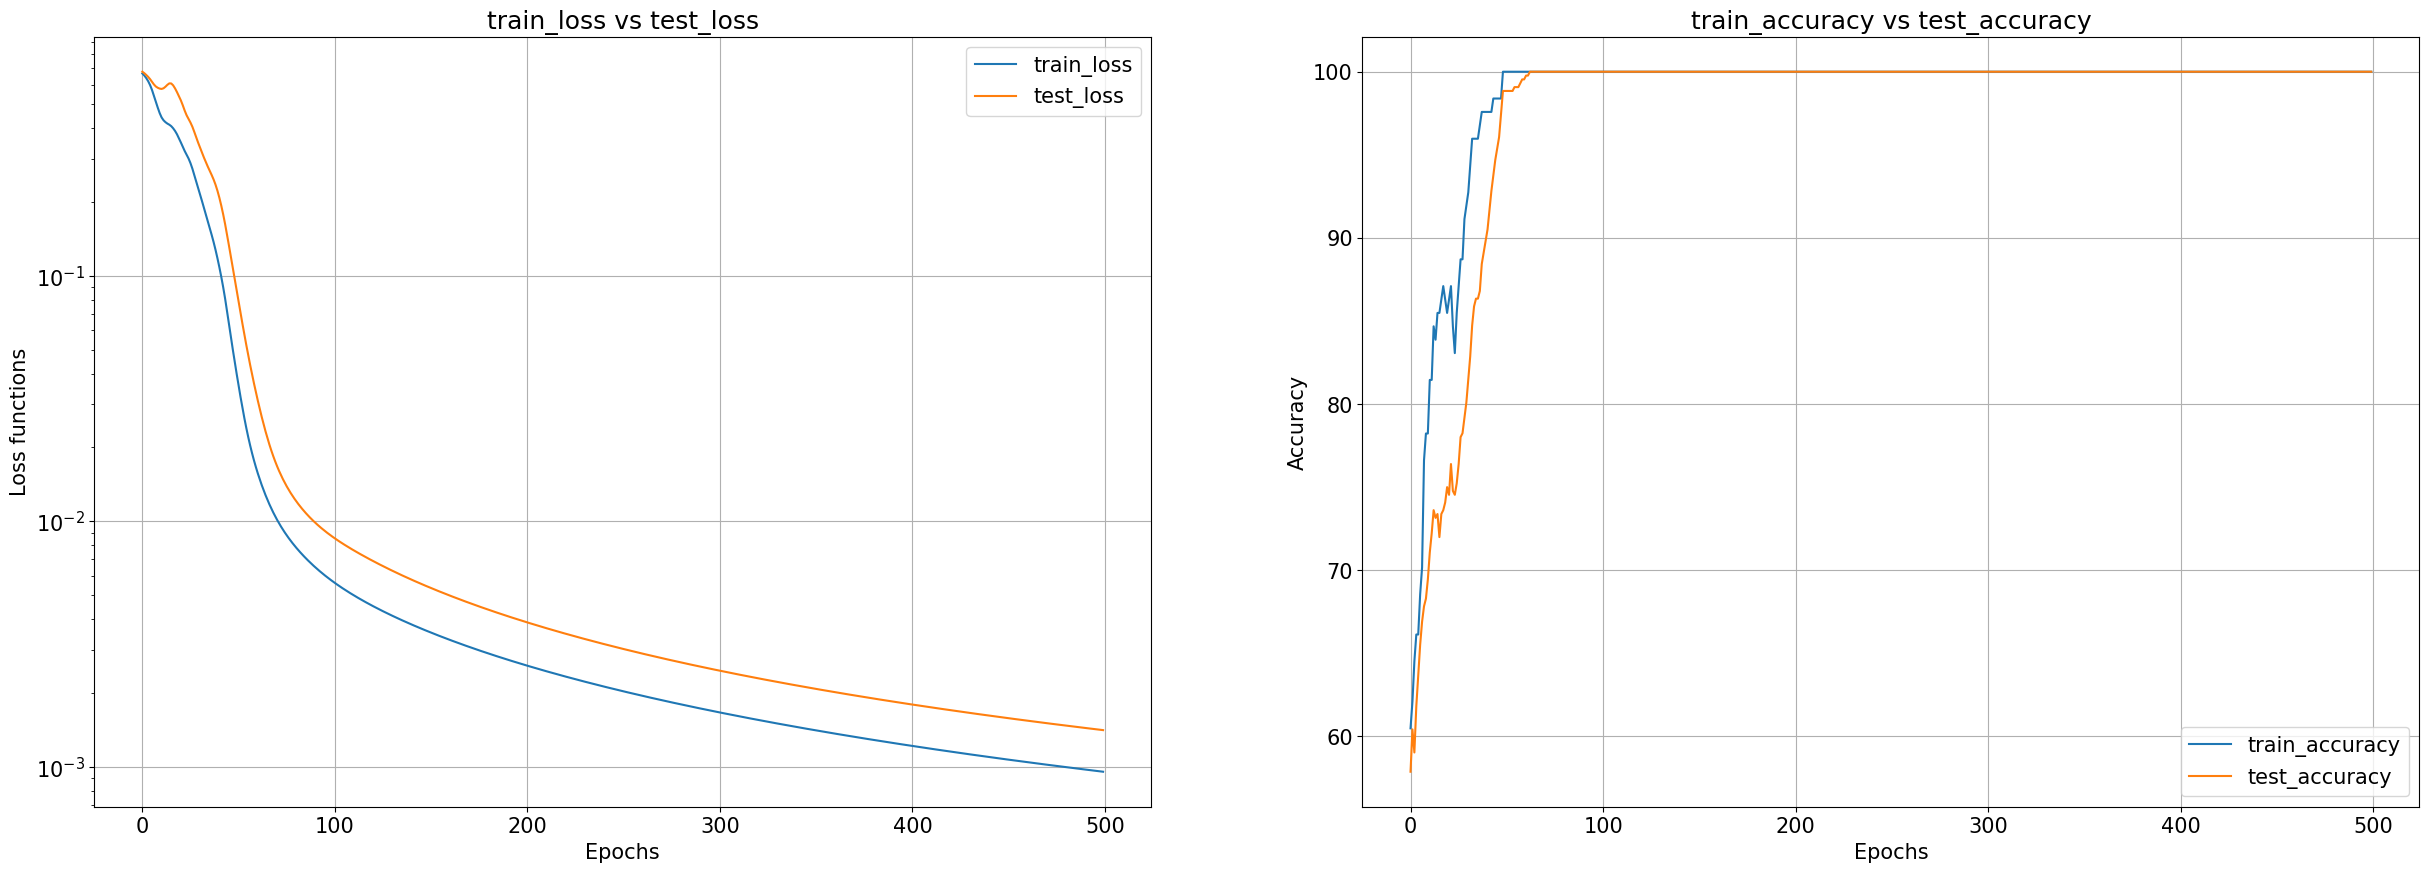

In [19]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonest['train_loss'],label='train_loss')
plt.plot(history_nonest['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonest['train_accuracy'],label='train_accuracy')
plt.plot(history_nonest['test_accuracy'], label='test_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### Nestorov momentum


Build model


In [20]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
output_layer = Layer(hidden_layer, 1, 'sigm')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

model.set_initial_weights(init_weights_list)

Training with Nestorov momentum:


In [21]:
np.random.seed(seed)
params['nest'] = True
history_nest = model.retrain(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    test_data = [X_test_monk,y_test_monk.reshape((1,X_test_monk.shape[1]))],
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )


Epoch 0: train_loss: 6.670e-01, test_loss: 6.781e-01; train_accuracy: 6.048e+01, test_accuracy: 5.787e+01  train_MSE: 2.371e-01, test_MSE: 2.426e-01  lr : 0.5
Epoch 1: train_loss: 6.549e-01, test_loss: 6.692e-01; train_accuracy: 6.371e+01, test_accuracy: 6.134e+01  train_MSE: 2.312e-01, test_MSE: 2.382e-01  lr : 0.5
Epoch 2: train_loss: 6.389e-01, test_loss: 6.582e-01; train_accuracy: 6.613e+01, test_accuracy: 5.995e+01  train_MSE: 2.234e-01, test_MSE: 2.329e-01  lr : 0.5
Epoch 3: train_loss: 6.191e-01, test_loss: 6.454e-01; train_accuracy: 6.694e+01, test_accuracy: 6.134e+01  train_MSE: 2.140e-01, test_MSE: 2.267e-01  lr : 0.5
Epoch 4: train_loss: 5.950e-01, test_loss: 6.307e-01; train_accuracy: 6.613e+01, test_accuracy: 6.319e+01  train_MSE: 2.027e-01, test_MSE: 2.199e-01  lr : 0.5
Epoch 5: train_loss: 5.669e-01, test_loss: 6.148e-01; train_accuracy: 6.935e+01, test_accuracy: 6.551e+01  train_MSE: 1.902e-01, test_MSE: 2.127e-01  lr : 0.5
Epoch 6: train_loss: 5.364e-01, test_loss: 5.9

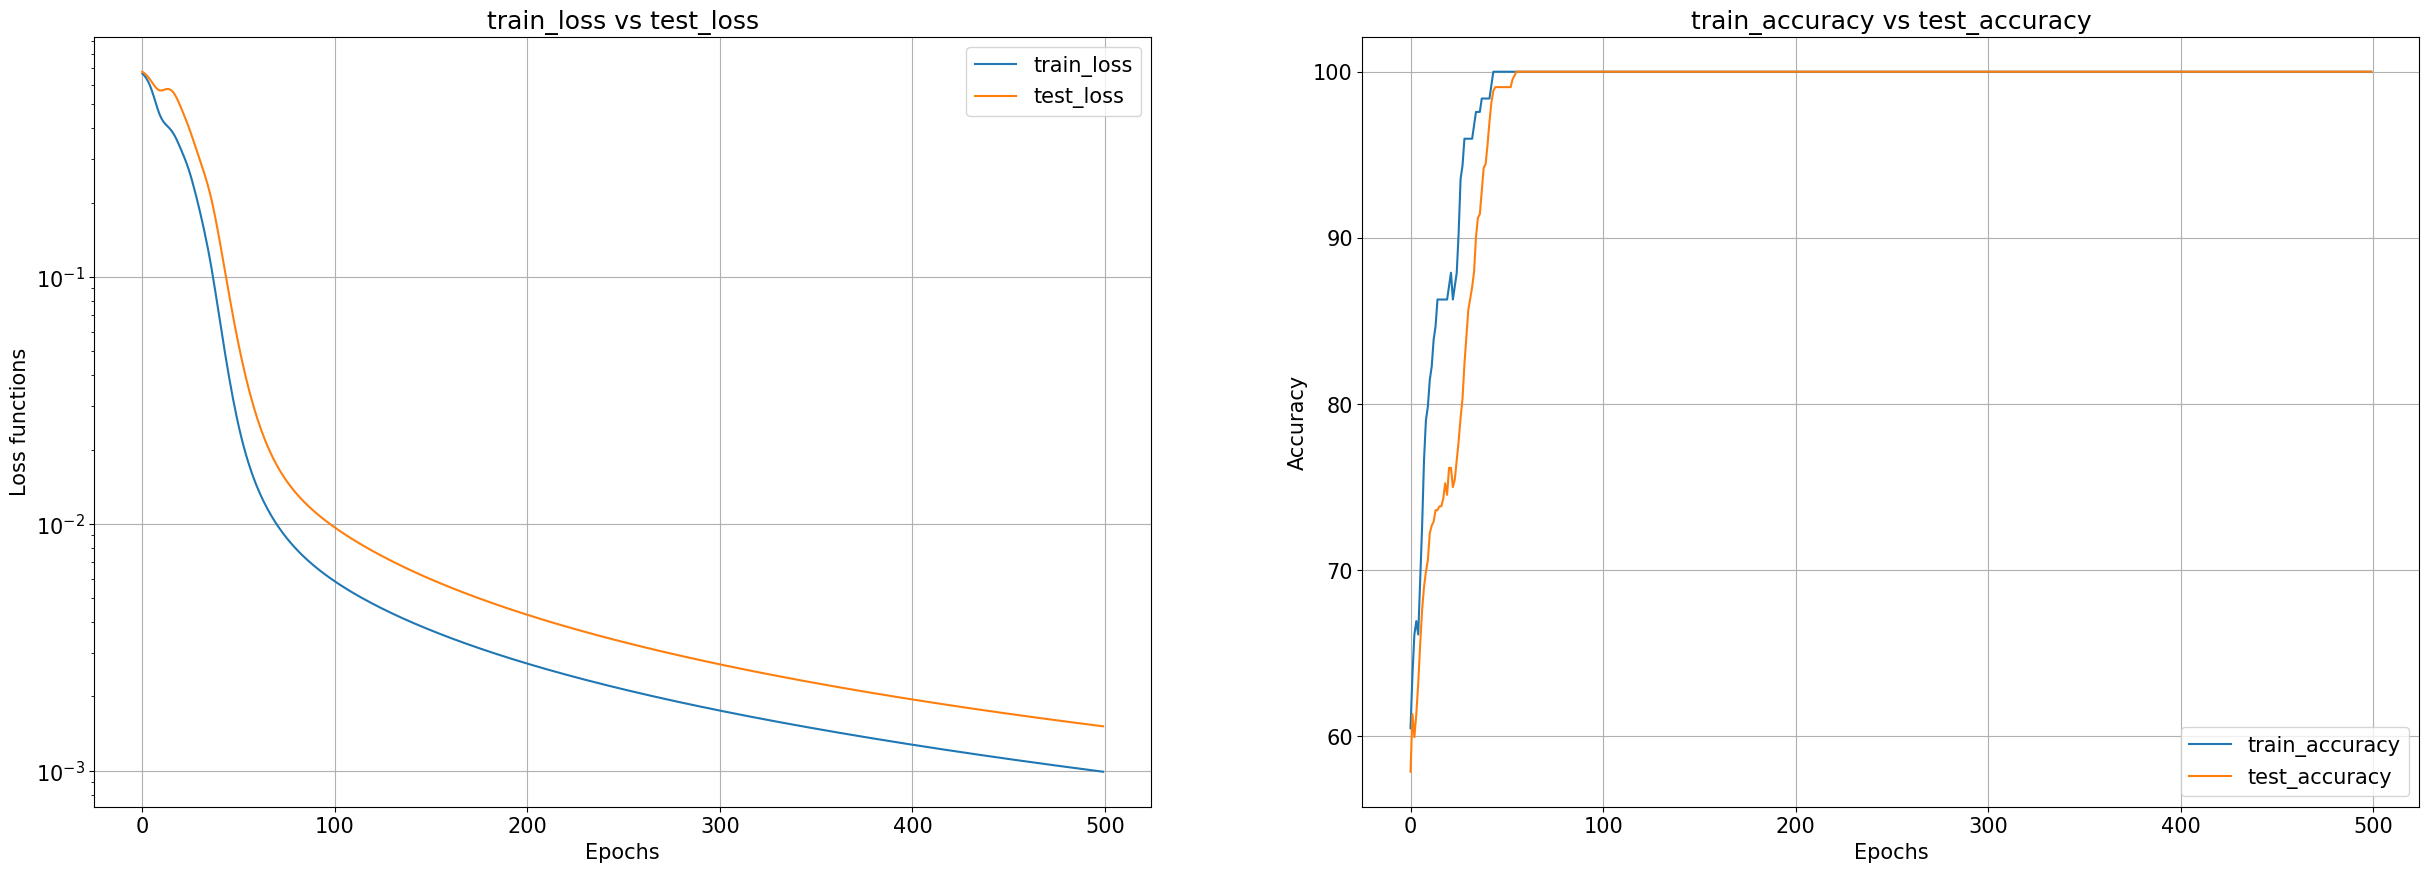

In [22]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nest['train_loss'],label='train_loss')
plt.plot(history_nest['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nest['train_accuracy'],label='train_accuracy')
plt.plot(history_nest['test_accuracy'], label='test_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

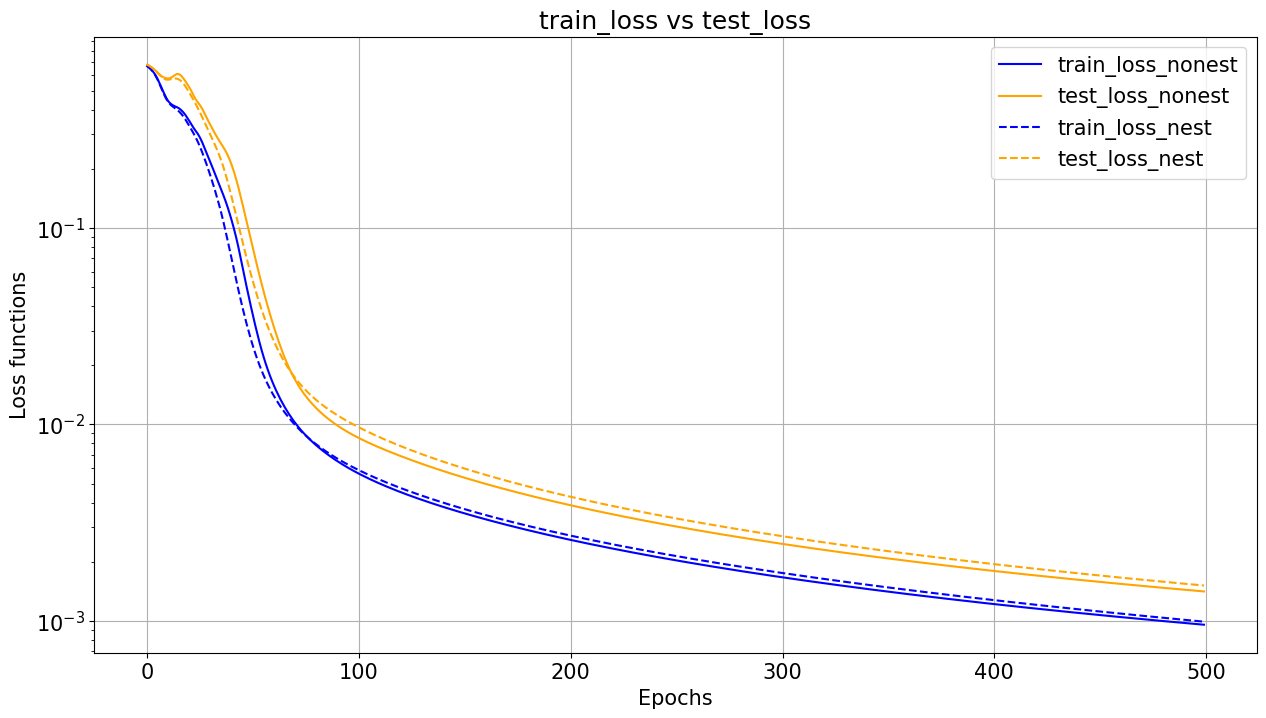

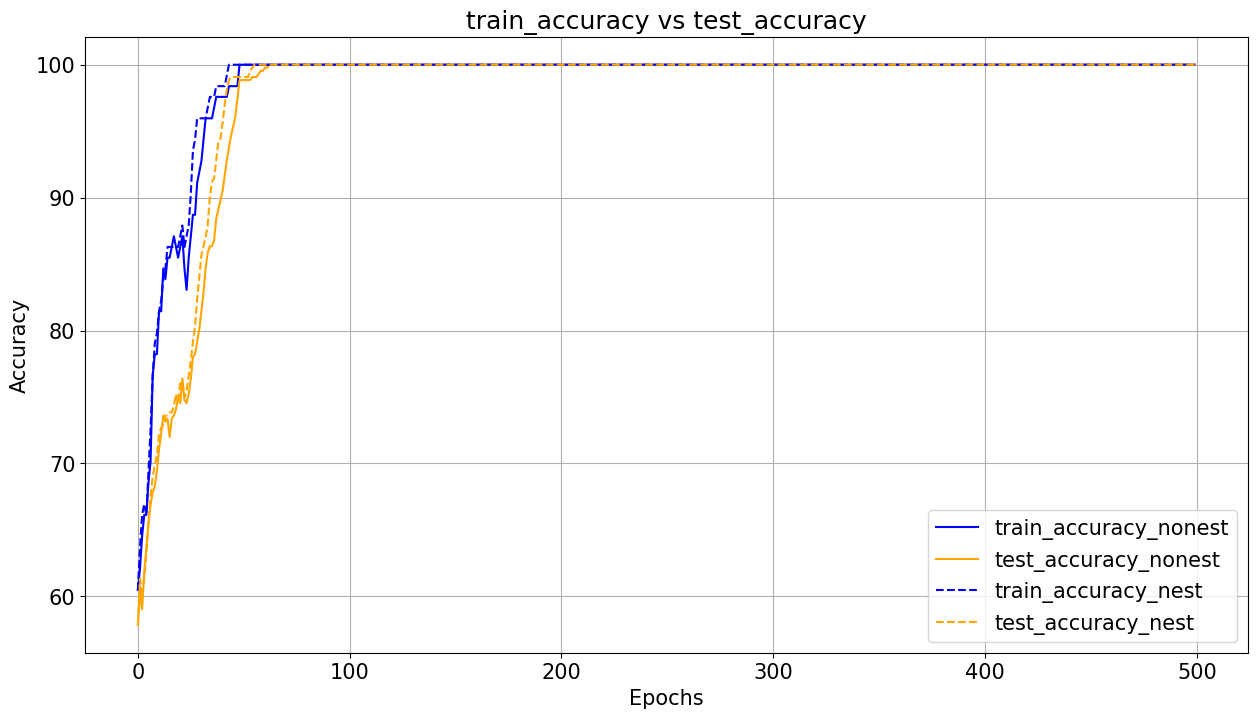

In [23]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonest['train_loss'], '-', label='train_loss_nonest', color='blue')
plt.plot(history_nonest['test_loss'], '-', label='test_loss_nonest', color='orange')
plt.plot(history_nest['train_loss'], '--', label='train_loss_nest', color='blue')
plt.plot(history_nest['test_loss'], '--', label='test_loss_nest', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonest['train_accuracy'], '-',label='train_accuracy_nonest', color='blue')
plt.plot(history_nonest['test_accuracy'], '-', label='test_accuracy_nonest', color='orange')
plt.plot(history_nest['train_accuracy'], '--', label='train_accuracy_nest', color='blue')
plt.plot(history_nest['test_accuracy'], '--', label='test_accuracy_nest', color='orange')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs test_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

## CUP

Define training and model hyperparameters

In [24]:
orig_params = {'hidden_dim': 50,
        'hidden_act_func': 'tanh',
        'hidden_dim2': 50,
        'hidden_act_func2' : 'tanh',
        'eta': 0.001,
        'lam': 0.000,
        'alpha': 0.9,
        'n_batch': 150,
        'use_opt':0,
        'nest': True,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(10,1000)

### Normal momentum

Build model

In [25]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_weights_list()

Training with normal momentum:

In [26]:
np.random.seed(seed)
params['nest'] = False
history_nonest = model.retrain(X_train_cup, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 5.423e+02, test_loss: 5.805e+02; train_MEE: 3.554e+01, test_MEE: 3.673e+01  lr : 0.001
Epoch 1: train_loss: 2.559e+02, test_loss: 2.794e+02; train_MEE: 2.404e+01, test_MEE: 2.518e+01  lr : 0.001
Epoch 2: train_loss: 9.554e+01, test_loss: 1.049e+02; train_MEE: 1.479e+01, test_MEE: 1.552e+01  lr : 0.001
Epoch 3: train_loss: 5.548e+01, test_loss: 5.809e+01; train_MEE: 1.166e+01, test_MEE: 1.192e+01  lr : 0.001
Epoch 4: train_loss: 4.247e+01, test_loss: 4.322e+01; train_MEE: 1.027e+01, test_MEE: 1.039e+01  lr : 0.001
Epoch 5: train_loss: 3.206e+01, test_loss: 3.345e+01; train_MEE: 8.857e+00, test_MEE: 9.145e+00  lr : 0.001
Epoch 6: train_loss: 2.827e+01, test_loss: 3.016e+01; train_MEE: 8.082e+00, test_MEE: 8.506e+00  lr : 0.001
Epoch 7: train_loss: 2.498e+01, test_loss: 2.621e+01; train_MEE: 7.570e+00, test_MEE: 7.847e+00  lr : 0.001
Epoch 8: train_loss: 2.123e+01, test_loss: 2.230e+01; train_MEE: 6.926e+00, test_MEE: 7.200e+00  lr : 0.001
Epoch 9: train_loss: 1.850e+

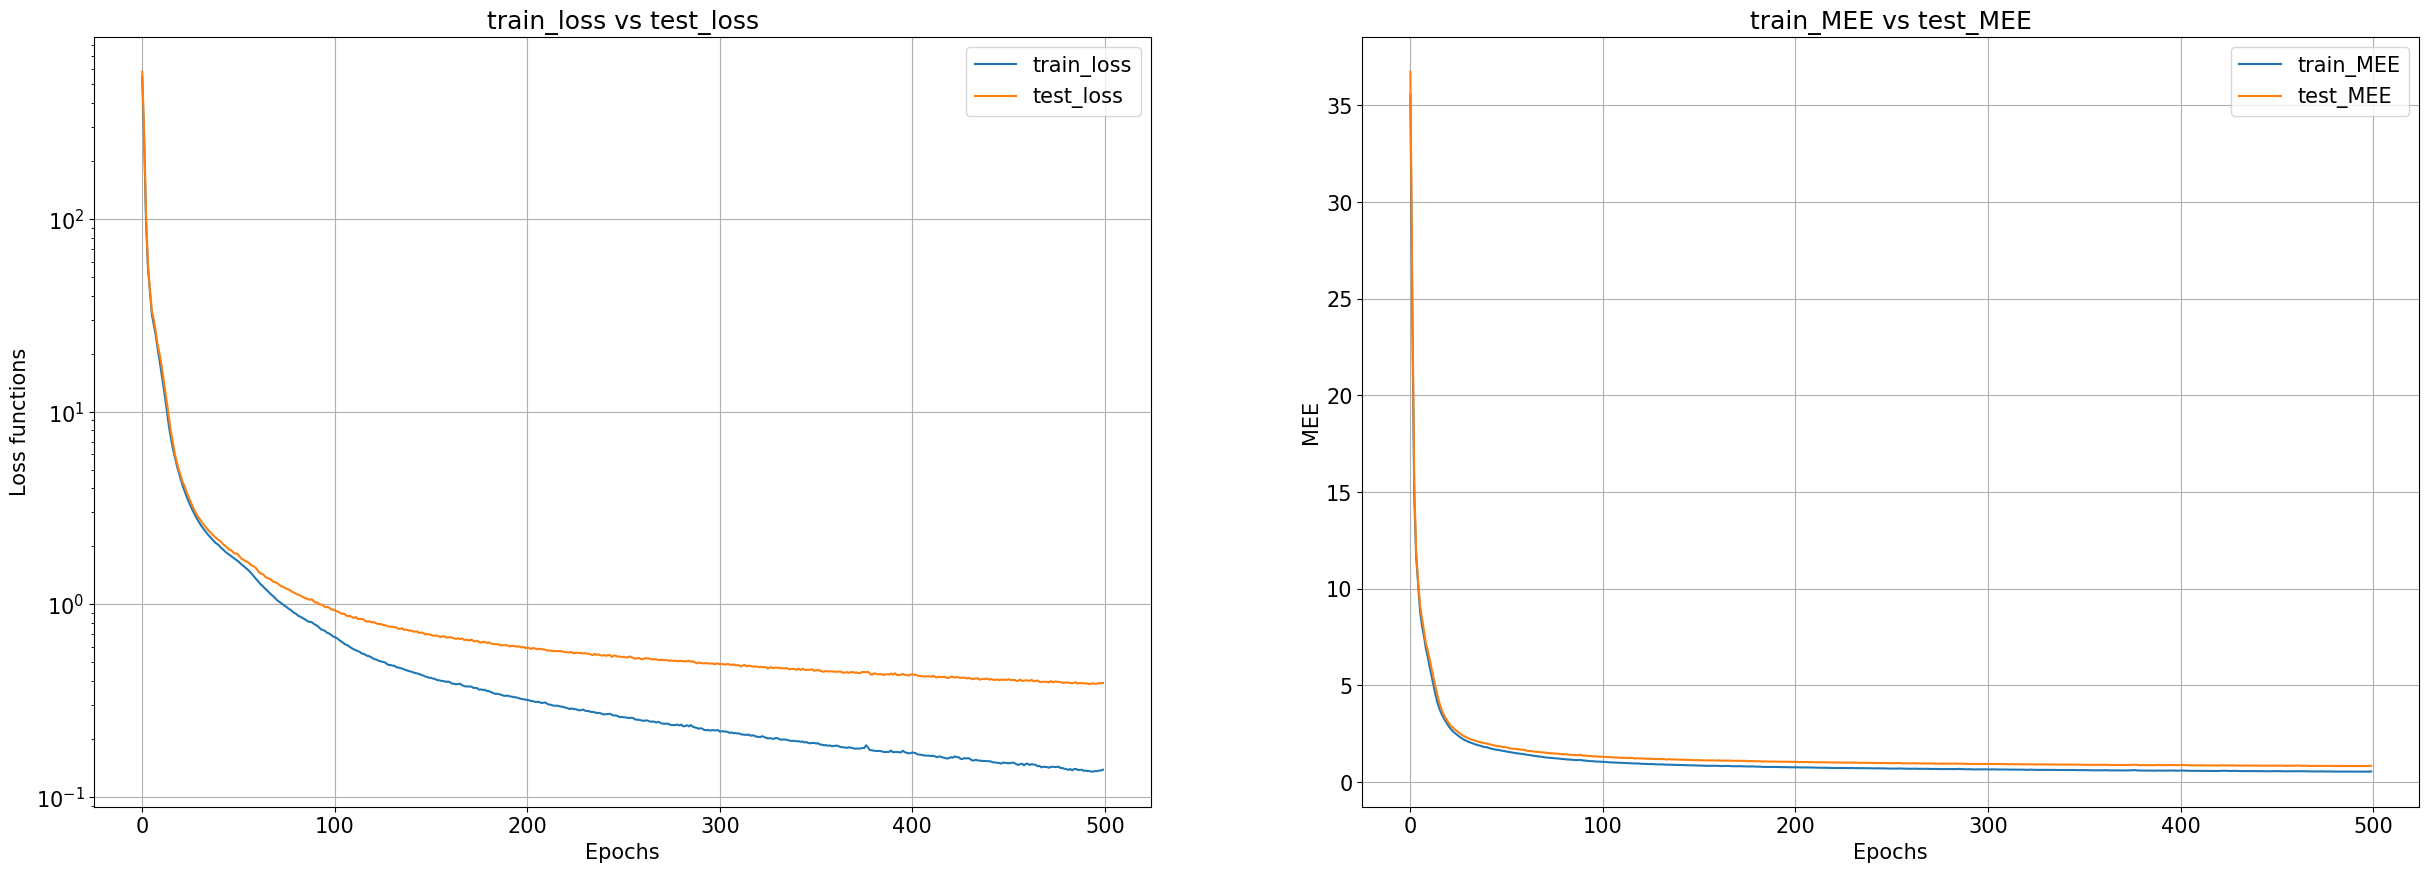

In [27]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonest['train_loss'],label='train_loss')
plt.plot(history_nonest['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonest['train_MEE'],label='train_MEE')
plt.plot(history_nonest['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### Nestorov momentum


Build model


In [28]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training with L1 regularization:


In [29]:
np.random.seed(seed)
params['nest'] = True
history_nest = model.retrain(X_train_cup, y_train_cup,
                                    ** params,
                                    test_data=[X_test_cup, y_test_cup],
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 5.412e+02, test_loss: 5.796e+02; train_MEE: 3.548e+01, test_MEE: 3.668e+01  lr : 0.001
Epoch 1: train_loss: 2.440e+02, test_loss: 2.671e+02; train_MEE: 2.315e+01, test_MEE: 2.429e+01  lr : 0.001
Epoch 2: train_loss: 8.699e+01, test_loss: 9.688e+01; train_MEE: 1.384e+01, test_MEE: 1.466e+01  lr : 0.001
Epoch 3: train_loss: 4.713e+01, test_loss: 5.074e+01; train_MEE: 1.066e+01, test_MEE: 1.107e+01  lr : 0.001
Epoch 4: train_loss: 3.512e+01, test_loss: 3.566e+01; train_MEE: 9.285e+00, test_MEE: 9.398e+00  lr : 0.001
Epoch 5: train_loss: 2.608e+01, test_loss: 2.719e+01; train_MEE: 7.910e+00, test_MEE: 8.191e+00  lr : 0.001
Epoch 6: train_loss: 2.137e+01, test_loss: 2.278e+01; train_MEE: 7.014e+00, test_MEE: 7.381e+00  lr : 0.001
Epoch 7: train_loss: 1.777e+01, test_loss: 1.870e+01; train_MEE: 6.315e+00, test_MEE: 6.585e+00  lr : 0.001
Epoch 8: train_loss: 1.473e+01, test_loss: 1.536e+01; train_MEE: 5.672e+00, test_MEE: 5.901e+00  lr : 0.001
Epoch 9: train_loss: 1.179e+

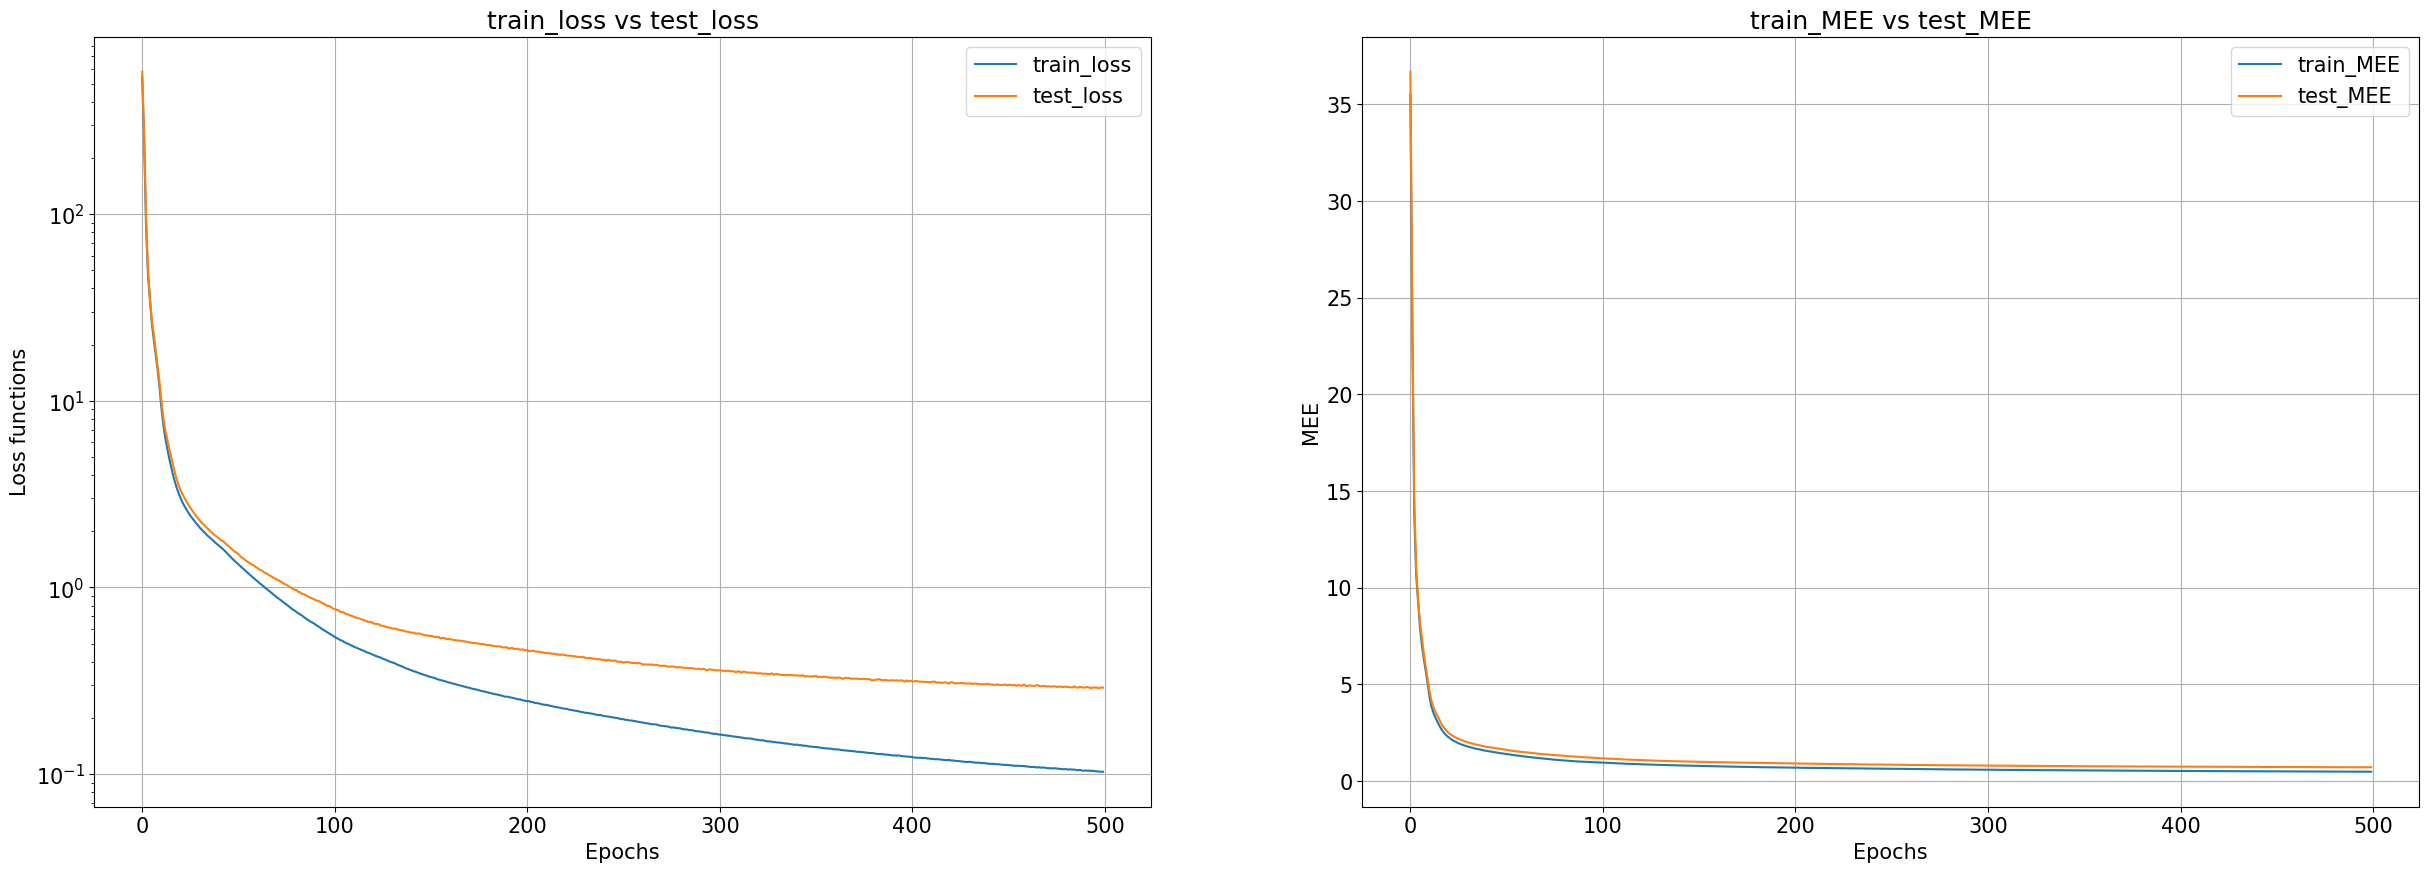

In [30]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nest['train_loss'],label='train_loss')
plt.plot(history_nest['test_loss'], label='test_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nest['train_MEE'],label='train_MEE')
plt.plot(history_nest['test_MEE'], label='test_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

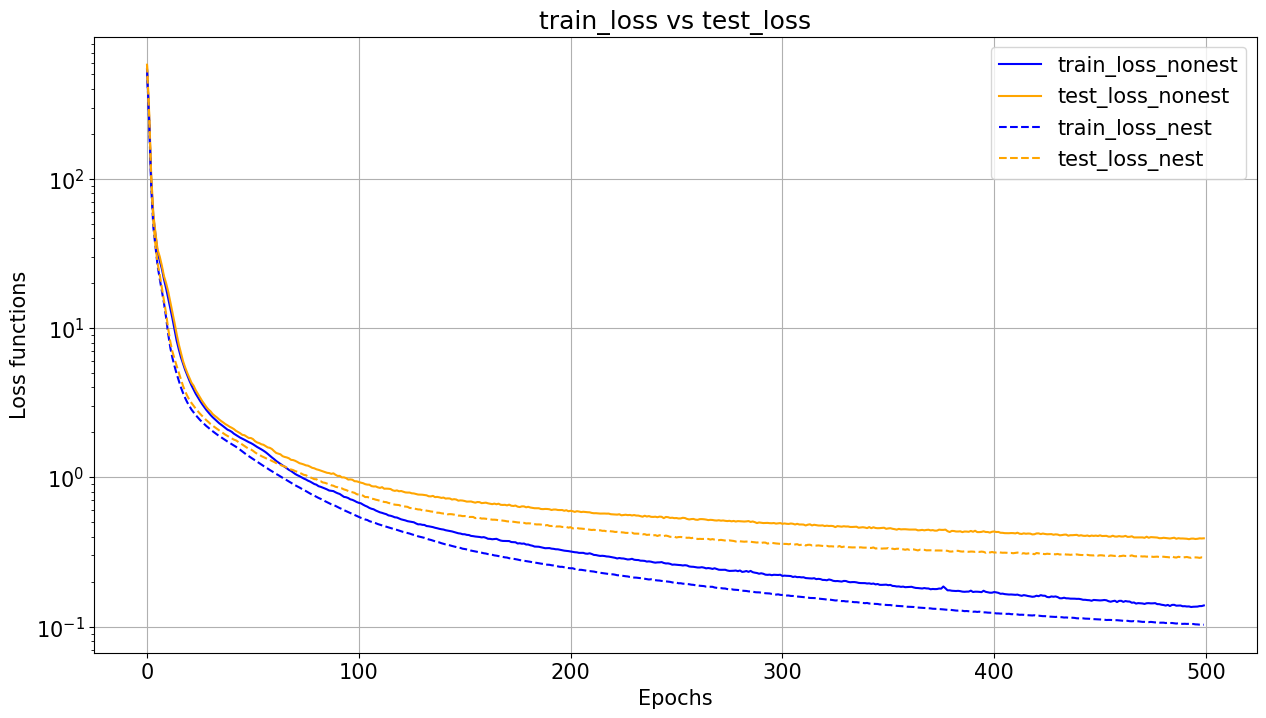

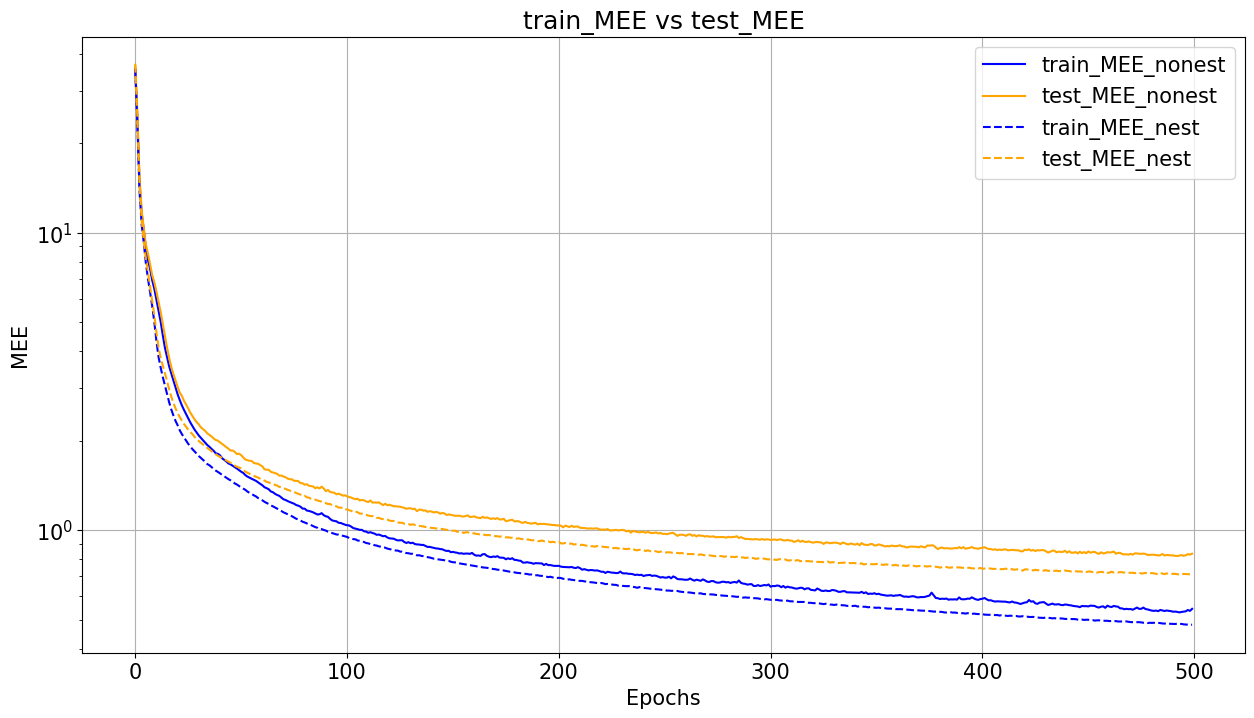

In [31]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonest['train_loss'], '-', label='train_loss_nonest', color='blue')
plt.plot(history_nonest['test_loss'], '-', label='test_loss_nonest', color='orange')
plt.plot(history_nest['train_loss'], '--', label='train_loss_nest', color='blue')
plt.plot(history_nest['test_loss'], '--', label='test_loss_nest', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs test_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonest['train_MEE'], '-',label='train_MEE_nonest', color='blue')
plt.plot(history_nonest['test_MEE'], '-', label='test_MEE_nonest', color='orange')
plt.plot(history_nest['train_MEE'], '--', label='train_MEE_nest', color='blue')
plt.plot(history_nest['test_MEE'], '--', label='test_MEE_nest', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs test_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)